In [1]:
import pandas as pd
import sys
import os
import numpy as np
import scipy.stats as stats


In [2]:
data_path = '../datasets/insurance_data_cleaned.csv'

In [3]:
df = pd.read_csv(data_path)

/tmp/ipykernel_27598/606058143.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [4]:
# Quick look
print(df.shape)
print(df.dtypes)
df.head()

(1000098, 52)
UnderwrittenCoverID           int64
PolicyID                      int64
TransactionMonth             object
IsVATRegistered                bool
Citizenship                  object
LegalType                    object
Title                        object
Language                     object
Bank                         object
AccountType                  object
MaritalStatus                object
Gender                       object
Country                      object
Province                     object
PostalCode                    int64
MainCrestaZone               object
SubCrestaZone                object
ItemType                     object
mmcode                      float64
VehicleType                  object
RegistrationYear              int64
make                         object
Model                        object
Cylinders                   float64
cubiccapacity               float64
kilowatts                   float64
bodytype                     object
NumberOfDoors 

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [5]:
# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])

# Drop or fill based on context
df['TotalPremium'] = df['TotalPremium'].fillna(0)
df['TotalClaims'] = df['TotalClaims'].fillna(0)

# Drop rows with essential info missing (e.g. PolicyID)
df = df.dropna(subset=['PolicyID', 'TransactionMonth'])


NumberOfVehiclesInFleet    1000098
dtype: int64


In [6]:
# Claim Frequency (per PolicyID): binary column
df['HadClaim'] = df['TotalClaims'].apply(lambda x: 1 if x > 0 else 0)

# Claim Severity (only for rows with claims > 0)
df['ClaimSeverity'] = df['TotalClaims'] / df['HadClaim'].replace(0, pd.NA)

# Margin = Premium - Claims
df['Margin'] = df['TotalPremium'] - df['TotalClaims']


In [7]:
policy_level = df.groupby("PolicyID").agg({
    'TotalPremium': 'sum',
    'TotalClaims': 'sum',
    'HadClaim': 'mean',
    'Margin': 'sum',
    'ClaimSeverity': 'mean'
}).rename(columns={
    'HadClaim': 'ClaimFrequency',
    'ClaimSeverity': 'AvgClaimSeverity'
}).reset_index()


In [8]:
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,HadClaim,ClaimSeverity,Margin
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0,<NA>,21.929825
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0,<NA>,21.929825
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0,<NA>,0.000000
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,0,<NA>,512.848070
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0,<NA>,0.000000


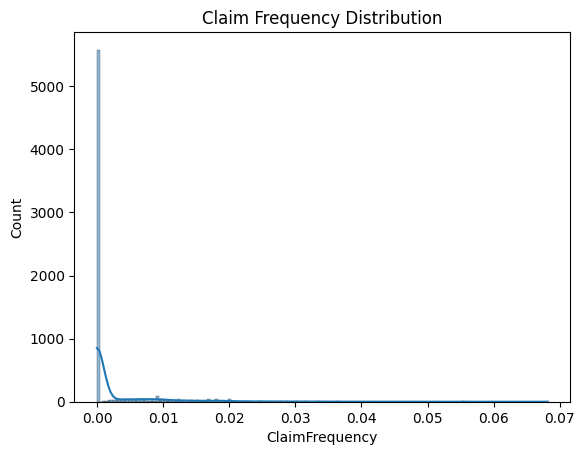

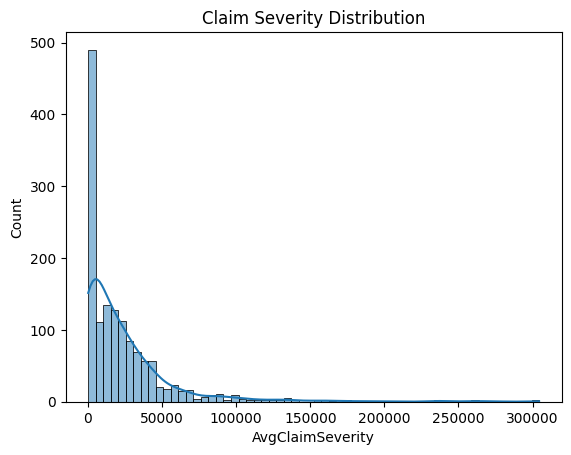

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(policy_level['ClaimFrequency'], kde=True)
plt.title("Claim Frequency Distribution")
plt.show()

sns.histplot(policy_level['AvgClaimSeverity'], kde=True)
plt.title("Claim Severity Distribution")
plt.show()


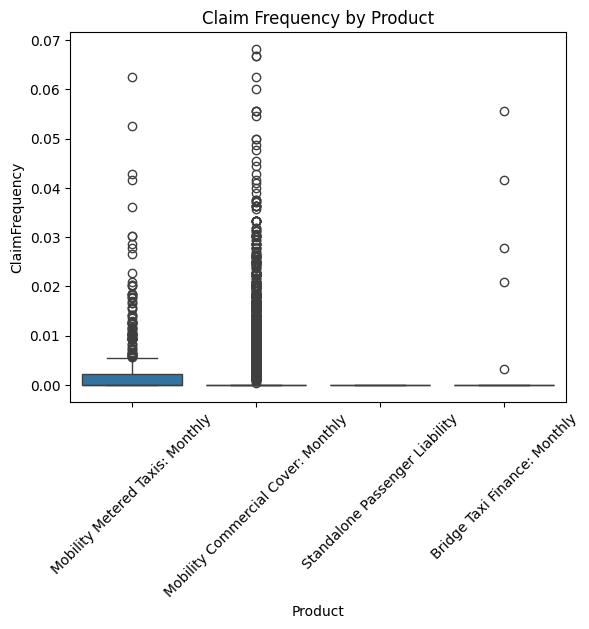

In [10]:
# Merge back segment info
segments = df[['PolicyID', 'Product', 'LegalType', 'Citizenship']].drop_duplicates()
policy_level = policy_level.merge(segments, on='PolicyID', how='left')

# Plot claim frequency by product
sns.boxplot(x='Product', y='ClaimFrequency', data=policy_level)
plt.xticks(rotation=45)
plt.title('Claim Frequency by Product')
plt.show()


### Hypothesis Testing

In [11]:

sys.path.append("../src")

from hypothesis_testing import (
    calculate_kpis,
    hypothesis_test_by_group,
    interpret_result,
    run_ttest,
    run_chi_squared
)

In [12]:



# Prepare KPI data
df_kpi = calculate_kpis(df)

# -- H₀₁: Province & Claim Frequency
print("H₀₁: Risk difference across Provinces")
results_h1 = hypothesis_test_by_group(df_kpi, 'Province', 'ClaimFrequency')
for k, p in results_h1.items():
    print(f"{k}: p = {p:.4f} → {interpret_result(p)}")

# -- H₀₂: Zip Code & Claim Frequency
# print("\nH₀₂: Risk difference across Zip Codes (sample)")
# results_h2 = hypothesis_test_by_group(df_kpi, 'PostalCode', 'ClaimFrequency')
# for k, p in list(results_h2.items())[:5]:  # Show first 5 comparisons
#     print(f"{k}: p = {p:.4f} → {interpret_result(p)}")

# -- H₀₃: Zip Code & Margin
# print("\nH₀₃: Margin difference across Zip Codes (sample)")
# results_h3 = hypothesis_test_by_group(df_kpi, 'PostalCode', 'Margin')
# for k, p in list(results_h3.items())[:5]:
#     print(f"{k}: p = {p:.4f} → {interpret_result(p)}")

# -- H₀₄: Gender & Claim Frequency
group_m = df_kpi[df_kpi['Gender'] == 'Male']
group_f = df_kpi[df_kpi['Gender'] == 'Female']
p_val_h4 = run_ttest(group_m, group_f, 'ClaimFrequency')
print("\nH₀₄: Risk difference between Men and Women")
print(f"p = {p_val_h4:.4f} → {interpret_result(p_val_h4)}")


H₀₁: Risk difference across Provinces
Gauteng vs KwaZulu-Natal: p = 0.0000 → Reject H₀
Gauteng vs Mpumalanga: p = 0.0000 → Reject H₀
Gauteng vs Eastern Cape: p = 0.0000 → Reject H₀
Gauteng vs Western Cape: p = 0.0000 → Reject H₀
Gauteng vs Limpopo: p = 0.0000 → Reject H₀
Gauteng vs North West: p = 0.0000 → Reject H₀
Gauteng vs Free State: p = 0.0000 → Reject H₀
Gauteng vs Northern Cape: p = 0.0000 → Reject H₀
KwaZulu-Natal vs Mpumalanga: p = 0.0000 → Reject H₀
KwaZulu-Natal vs Eastern Cape: p = 0.0000 → Reject H₀
KwaZulu-Natal vs Western Cape: p = 0.0000 → Reject H₀
KwaZulu-Natal vs Limpopo: p = 0.0000 → Reject H₀
KwaZulu-Natal vs North West: p = 0.0000 → Reject H₀
KwaZulu-Natal vs Free State: p = 0.0000 → Reject H₀
KwaZulu-Natal vs Northern Cape: p = 0.0000 → Reject H₀
Mpumalanga vs Eastern Cape: p = 0.0000 → Reject H₀
Mpumalanga vs Western Cape: p = 0.0000 → Reject H₀
Mpumalanga vs Limpopo: p = 0.0000 → Reject H₀
Mpumalanga vs North West: p = 0.7429 → Fail to Reject H₀
Mpumalanga vs 

In [13]:
print("\nH₀₄ (Chi-squared): Gender vs Claim")
p_chi = run_chi_squared(df_kpi, 'Gender', 'Claim')
print(f"Chi-squared p = {p_chi:.4f} → {interpret_result(p_chi)}")



H₀₄ (Chi-squared): Gender vs Claim
Chi-squared p = 0.0303 → Reject H₀
